In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist_reader import *

# Gray-scales Samples

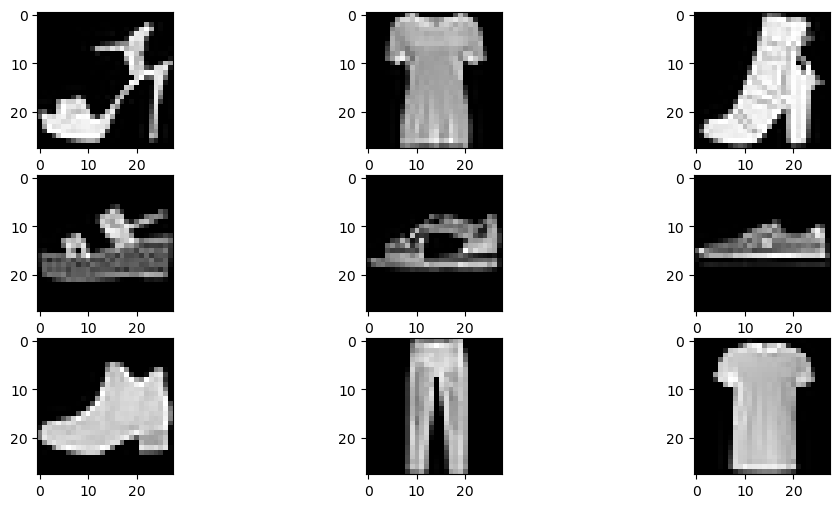

In [2]:
fig = plt.figure(figsize=(12,6))
for i, img in enumerate(get_images(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray');
plt.show()

# Binaries Images

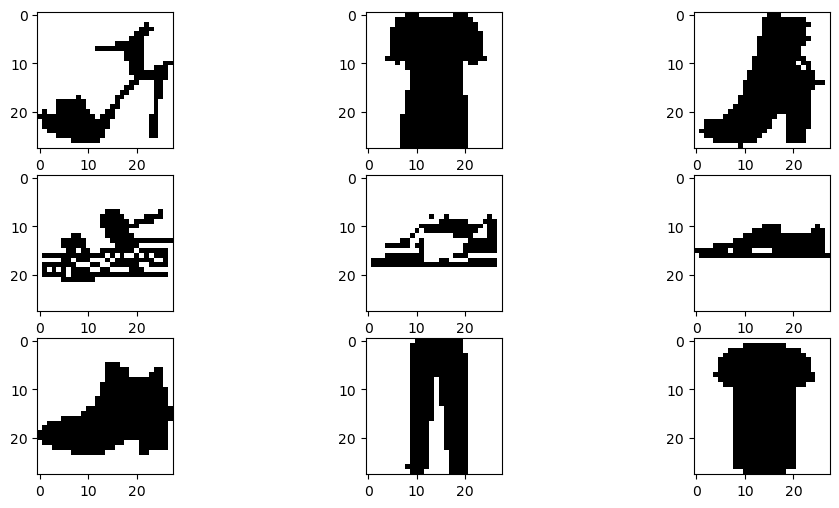

In [3]:
fig = plt.figure(figsize=(12,6))
for i, img in enumerate(get_binary_image(9)):
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray');
plt.show()

# Second Version: Higher capacity
### Memorising one image

> Here, we use polynomial degree four as the smoothing function

In [4]:
# Load one image
image = get_binary_image(1)[0]
print(f"Image shape: {image.shape}")
# Turn 2D image into 1D vector
image_1D = image.flatten()
print(f"1D vector shape: {image_1D.shape}")

# Smooth function
def F(x, n=4):
    return x**n

def Energy_poly(query_vector,meomoried_vectors):
    # First, calculate the inner product of the input query with
    # memorised vectors
    results = [np.dot(query_vector,mem_vec) for mem_vec in meomoried_vectors]
    # Then, transform it by the minus of the smooth function 'F'
    results = [-F(r) for r in results]
    # Finally, sum all the terms
    return np.sum(results)

Image shape: (28, 28)
1D vector shape: (784,)


# Mask half of the original images

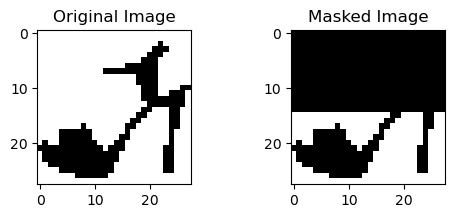

In [5]:
# Copy the original image first
masked_image = image.copy()
# Then, mask the upper half
masked_image[:15, :] = 0
fig = plt.figure(figsize=(6,2))
plt.subplot(121);plt.imshow(image, cmap='gray');plt.title("Original Image")
plt.subplot(122);plt.imshow(masked_image, cmap='gray');plt.title("Masked Image");plt.show()

# Query the masked image to retrieve the original one
### Paper: [Link](http://arxiv.org/abs/1606.01164)
### Algorithm:
#### $if E^{-}_i > E^{+}_i: V_i \rightarrow 1$.
#### $if E^{-}_i < E^{+}_i: V_i \rightarrow 0$.

#### where $E^{-}_i$ is there energy of  a vector when its $i$ element is set equal to $-1$, and similarly for $E^{+}_i$ for $+1$.

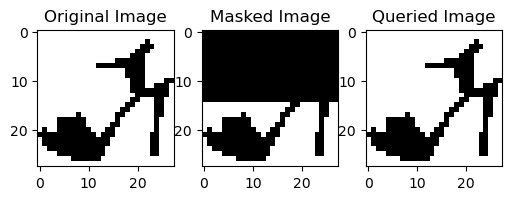

In [9]:
# 1D masked image
masked_image_1D = masked_image.flatten()
# An empty vector
retrieved_image_1D = np.zeros(masked_image_1D.shape)
for i in range(masked_image_1D.shape[0]):
    q_plus = masked_image_1D.copy()
    q_plus[i] = 1
    e_plus = Energy_poly(q_plus, [image.flatten()])
    q_minus = masked_image_1D.copy()
    q_minus[i] = -1
    e_minus = Energy_poly(q_minus, [image.flatten()])
    #    
    if e_minus > e_plus:
        retrieved_image_1D[i] = 1
    else:
        retrieved_image_1D[i] = 0
        
retrieved_image = retrieved_image_1D.copy().reshape((28, 28))
fig = plt.figure(figsize=(6,2))
plt.subplot(131);plt.imshow(image, cmap='gray');plt.title("Original Image")
plt.subplot(132);plt.imshow(masked_image, cmap='gray');plt.title("Masked Image")
plt.subplot(133);plt.imshow(retrieved_image, cmap='gray');plt.title("Queried Image");plt.show()

# Create some helper functions for masking images

In [10]:
def mask_my_image(img, x_slice=slice(0,15), y_slice=slice(0,28)):
    masked_image = img.copy()
    masked_image[x_slice, y_slice] = 0
    return masked_image

## This time, we will use an exponential as the smoothing function

> Note that the $\beta$ parameter in the F_exp function is the inverse temperature.

In [11]:
def F_exp(x, beta=2.0):
    return np.exp(beta * x)

def Energy_exp(query_vector,meomoried_vectors):
    # First, calculate the inner product of the input query with
    # memorised vectors
    results = [np.dot(query_vector,mem_vec) for mem_vec in meomoried_vectors]
    # Then, transform it by the minus of the smooth function 'F_exp'
    results = [-F_exp(r) for r in results]
    # Finally, sum all the terms
    return np.sum(results)

# Putting the algorithm in one function, we can query any masked images

In [12]:
def query(img, memorised_images):
    # 1D masked image
    masked_image_1D = img.flatten()
    memorised_images = [m.flatten() for m in memorised_images]
    # An empty vector
    retrieved_image_1D = np.zeros(masked_image_1D.shape)
    for i in range(masked_image_1D.shape[0]):
        q_plus = masked_image_1D.copy()
        q_plus[i] = 1
        e_plus = Energy_exp(q_plus, memorised_images)
        q_minus = masked_image_1D.copy()
        q_minus[i] = -1
        e_minus = Energy_exp(q_minus, memorised_images)
        #    
        if e_minus > e_plus:
            retrieved_image_1D[i] = 1
        else:
            retrieved_image_1D[i] = -1
        
        
    return retrieved_image_1D.reshape((28, 28))

# Now, lets try it for nine different examples

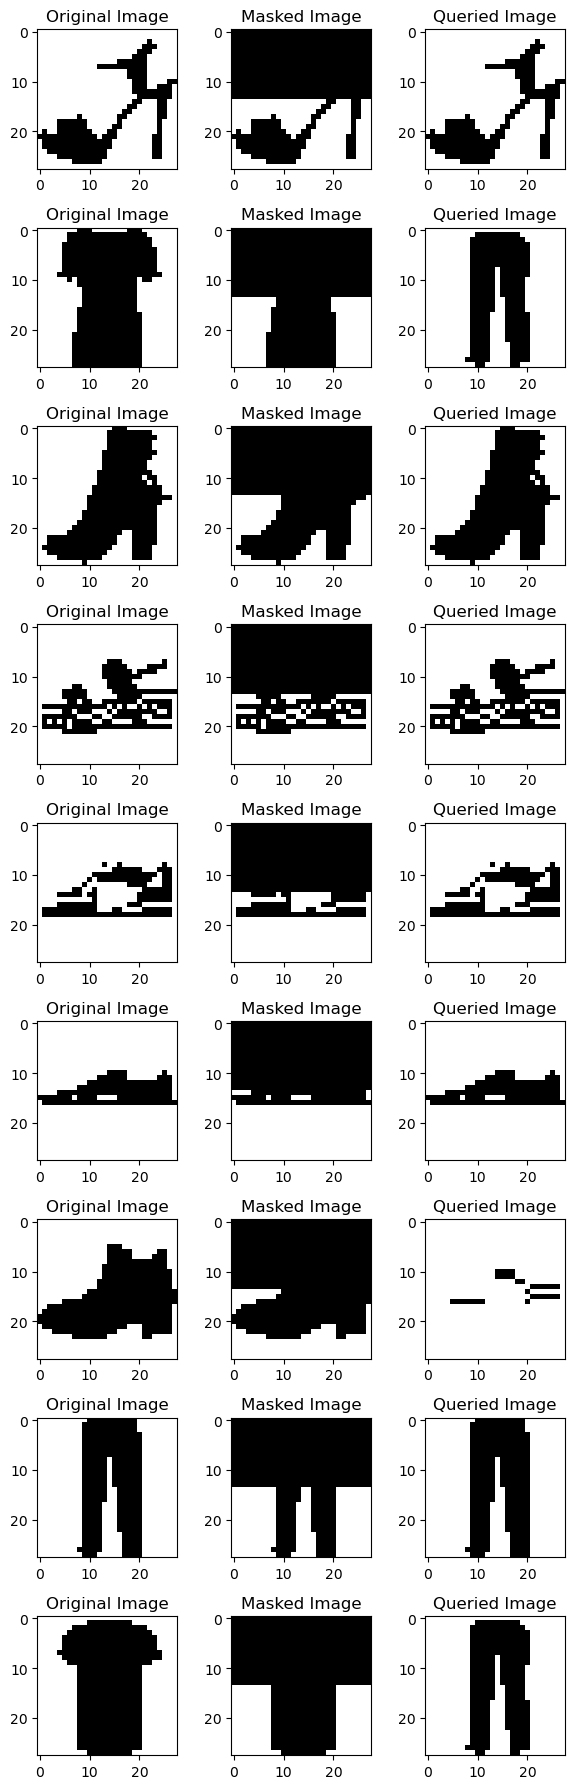

In [13]:
size=9
fig = plt.figure(figsize=(6,size*2))
index = 1
memorised_images = get_binary_image(size)
for img in memorised_images:
    plt.subplot(size,3,index);plt.title("Original Image")    
    plt.imshow(img, cmap='gray')
    #
    plt.subplot(size,3,index+1);plt.title("Masked Image")        
    masked_img = mask_my_image(img, slice(0, 14))
    plt.imshow(masked_img, cmap='gray')
    #
    plt.subplot(size,3,index+2);plt.title("Queried Image")    
    retrieved_img = query(masked_img, memorised_images)
    plt.imshow(retrieved_img, cmap='gray')
    index += 3

plt.tight_layout();plt.show()

# Implementing Log-Sum-Exp and Testing the temperature effect

> If you try higher $\beta$  values (smaller temperatures), you will get overflow error in exp function. To overcome this problem and test the effect of temperature, we first implement the log-sum-exp algorithm, and then, we can write a new query function

In [16]:
def log_sum_exp(x, beta=1.0):    
    max_x = np.max(x)
    shifted_x = x - max_x
    shifted_exp = np.exp(beta*shifted_x)
    sum_exp = np.sum(shifted_exp)
    log_sum_exp = beta*max_x + np.log(sum_exp)
    return log_sum_exp

In [38]:
def Energy_log_sum_exp(query_vector,meomoried_vectors, beta=1.0):
    # First, calculate the inner product of the input query with
    # memorised vectors
    results = np.array([np.dot(query_vector,mem_vec) for mem_vec in meomoried_vectors])
    # Find 'log_sum_exp' of the values
    results = log_sum_exp(results, beta)
    # Finally, using the exponential negate the log in 'log_sum_exp' 
    # and finds the energy
    return -np.exp(results.astype(np.float128))

def query2(img, memorised_images, beta=1.0):
    # 1D masked image
    masked_image_1D = img.flatten()
    memorised_images = [m.flatten() for m in memorised_images]
    # An empty vector
    retrieved_image_1D = np.zeros(masked_image_1D.shape)
    for i in range(masked_image_1D.shape[0]):
        q_plus = masked_image_1D.copy()
        q_plus[i] = 1
        e_plus = Energy_log_sum_exp(q_plus, memorised_images,beta)
        q_minus = masked_image_1D.copy()
        q_minus[i] = -1
        e_minus = Energy_log_sum_exp(q_minus, memorised_images,beta)
        #    
        if e_minus > e_plus:
            retrieved_image_1D[i] = 1
        else:
            retrieved_image_1D[i] = -1
        
        
    return retrieved_image_1D.reshape((28, 28))

# To see the effect of temperature, the model memorises nine images, and we gradually increase the temperature and query a single masked image

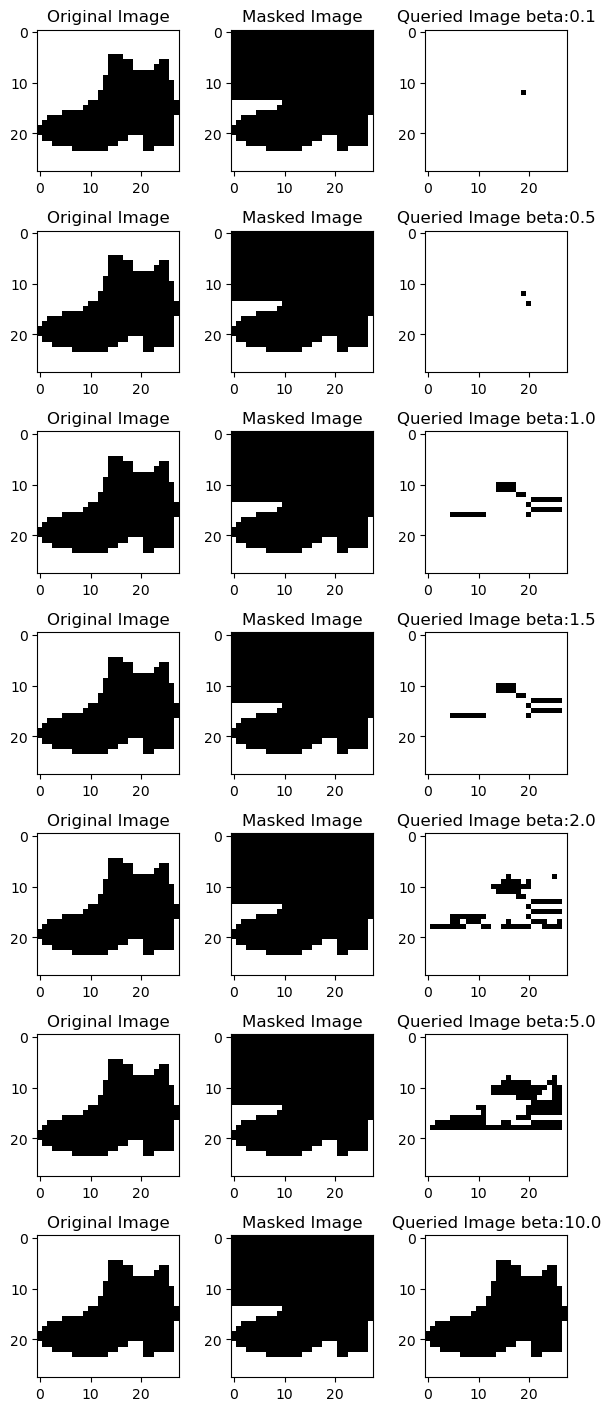

In [48]:
size=9
fig = plt.figure(figsize=(6,size*2))
index = 1
memorised_images = get_binary_image(size)

betas = [.1, .5, 1.0, 1.5, 2.0, 5.0, 10.0]
img = memorised_images[6]
for beta in betas:
    plt.subplot(size,3,index);plt.title("Original Image")    
    plt.imshow(img, cmap='gray')
    #
    plt.subplot(size,3,index+1);plt.title("Masked Image")        
    masked_img = mask_my_image(img, slice(0, 14))
    plt.imshow(masked_img, cmap='gray')
    #
    plt.subplot(size,3,index+2);plt.title(f"Queried Image beta:{beta}")    
    retrieved_img = query2(masked_img, memorised_images, beta)
    plt.imshow(retrieved_img, cmap='gray')
    index += 3

plt.tight_layout();plt.show()